No GPU available, using the CPU instead.


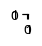

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

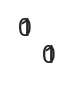

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


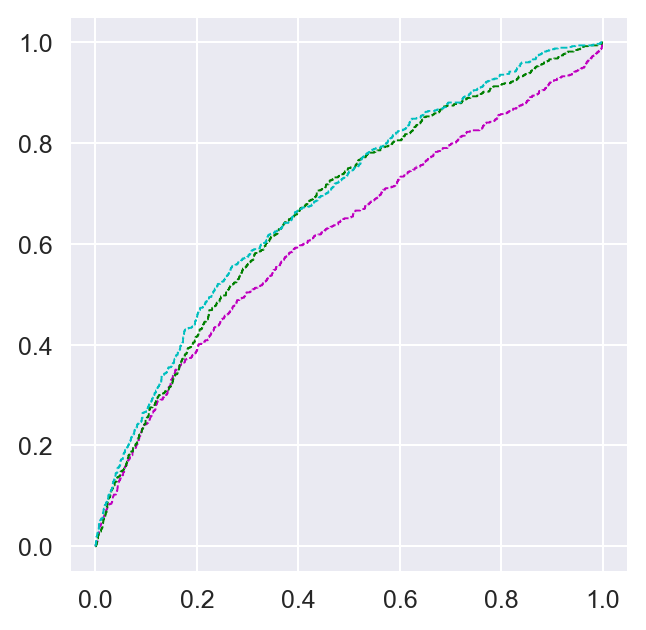

In [5]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [6]:
from src.baselines import plot_related_baseline_roc

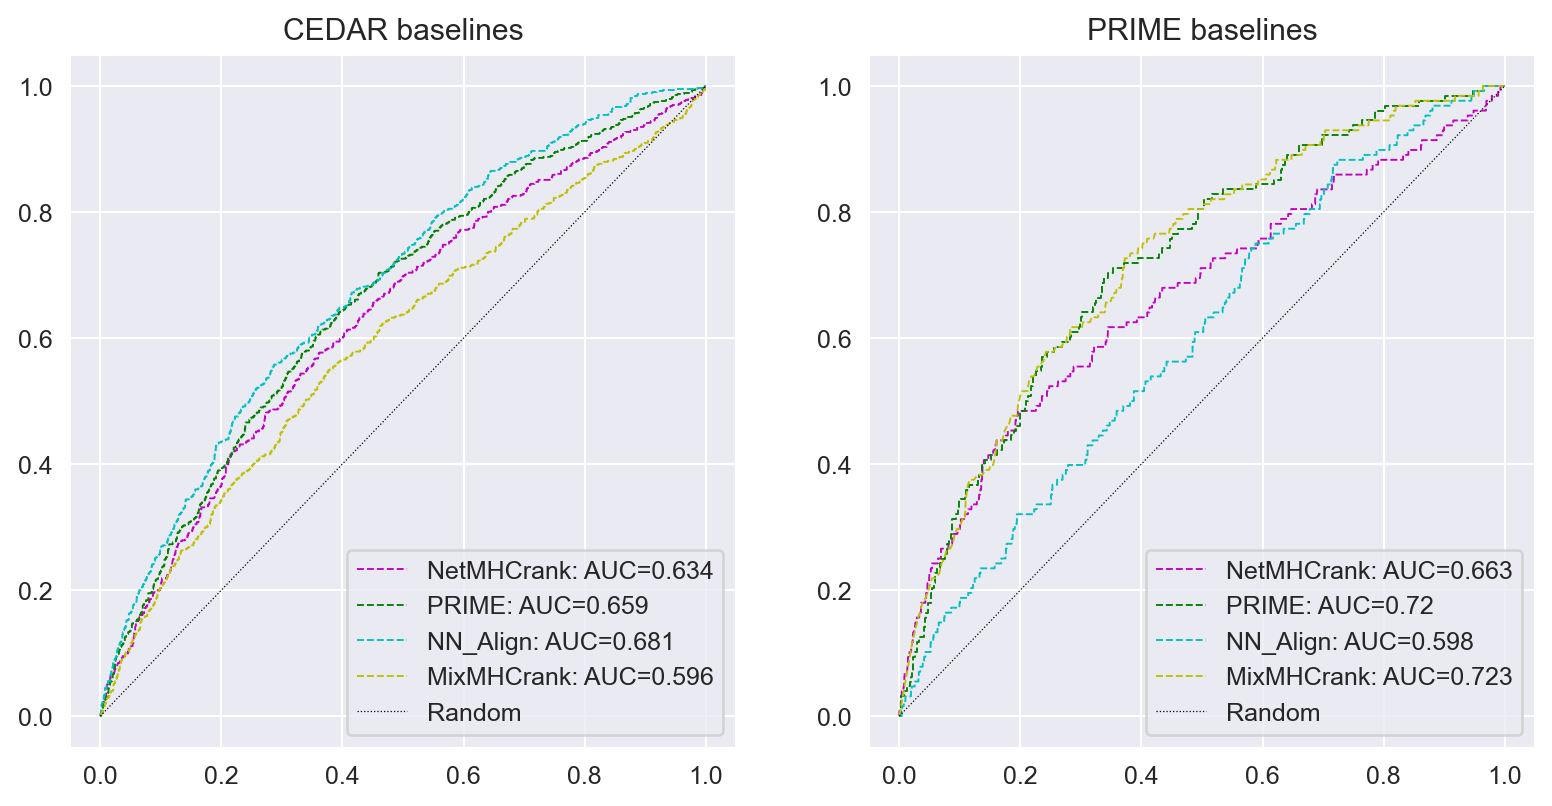

In [7]:
f,a = plt.subplots(1,2, figsize=(10.5,5))
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
a[0].set_title('CEDAR baselines')
a[1].set_title('PRIME baselines')
a[0].legend()
a[1].legend()

# Recheck all mutation scores etc and RESAVE datasets...

In [17]:
from src.mutation_tools import get_blsm_mutation_score, get_mutation_score

In [24]:
# How tf could this one be different???
cedar_related['ratio_rank'] = cedar_related['EL_rank_wt'] / cedar_related['EL_rank_mut']
prime_related['ratio_rank'] = prime_related['EL_rank_wt'] / prime_related['EL_rank_mut']
ibel['ratio_rank'] = ibel['EL_rank_wt'] / ibel['EL_rank_mut']

In [29]:
get_blsm_mutation_score??

Signature: get_blsm_mutation_score(mutation_positions, mutant, wildtype)
Source:   
def get_blsm_mutation_score(mutation_positions, mutant, wildtype):
    """
    Done as the log of the sum of mutation scores
    """
    positions = [int(x) for x in mutation_positions.split(',')]
    # print(positions, mutant, wildtype, type(positions[0]), type(mutant), mutant[positions[0]], wildtype[positions[0]])
    # Here take sum and not product because might be set to zero
    score = np.sum([BL62_MUT[mutant[x]][wildtype[x]] for x in positions])
    if score == -np.inf or score == np.nan:
        return -1
    else:
        return score
File:      ~/Documents/code/cedar/src/mutation_tools.py
Type:      function


In [28]:
get_mutation_score??

Signature: get_mutation_score(mutation_positions, mutant, wildtype)
Source:   
def get_mutation_score(mutation_positions, mutant, wildtype):
    """
    Done as the log of the sum of mutation scores
    """

    if mutant==wildtype:
        return 0
    positions = [int(x) for x in mutation_positions.split(',')]
    # Here take sum and not product because might be set to zero
    score = np.sum([MUT_MATRIX[mutant[x]][wildtype[x]] for x in positions])
    if score == -np.inf or score == np.nan:
        return -1
    else:
        return score
File:      ~/Documents/code/cedar/src/mutation_tools.py
Type:      function


In [30]:
cedar_related.columns

Index(['Peptide', 'HLA', 'EL_rank_mut', 'agg_label', 'fold', 'EL_rank_wt',
       'PMIDs', 'Peptide_mut', 'Peptide_wt', 'Pos_mut', 'Pos_wt',
       'Related Object_Ending Position', 'Related Object_Starting Position',
       'anchor_mutation', 'binder', 'blsm_mut_score', 'core',
       'core_blsm_mut_score', 'core_mut', 'core_mutation_position',
       'core_mutation_score', 'core_wt', 'dissimilarity_score', 'icore',
       'icore_mut', 'icore_wt', 'label', 'len', 'len_icore_mut',
       'len_icore_wt', 'len_pep_mut', 'len_pep_wt', 'len_wt', 'mhc_anchor',
       'mut_wt_sim', 'mutation_position', 'mutation_score', 'mutation_type',
       'percentage_pos', 'ratio_rank', 'responses', 'total_count', 'trainset',
       'trueHLA_EL_rank', 'wild_type', 'wt_EL_rank', 'wt_core', 'wt_true',
       'aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point',
       'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8'],
      dtype='object')

In [34]:
print(any(cedar_related['mutation_score'] != cedar_related.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))
print(any(prime_related['mutation_score'] != prime_related.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))
print(any(ibel['mutation_score'] != ibel.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))

False
False
False


In [35]:
print(any(cedar_related['core_mutation_score'] != cedar_related.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))
print(any(prime_related['core_mutation_score'] != prime_related.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))
print(any(ibel['core_mutation_score'] != ibel.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))

False
False
False


In [37]:
print(any(cedar_related['blsm_mut_score'] != cedar_related.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))
print(any(prime_related['blsm_mut_score'] != prime_related.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))
print(any(ibel['blsm_mut_score'] != ibel.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)))

False
False
False


In [38]:
print(any(cedar_related['core_blsm_mut_score'] != cedar_related.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))
print(any(prime_related['core_blsm_mut_score'] != prime_related.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))
print(any(ibel['core_blsm_mut_score'] != ibel.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)))

False
False
False


# Redo CEDAR training with random split instead of partitions

In [8]:
top_hlas = list(map(lambda x: 'HLA-'+x, ['A0201', 'A1101', 'A2402', 'B0702', 'B1501', 'B3501']))

In [16]:
for hla in top_hlas:
    print('\n',hla)
    cd = cedar_related.query('HLA==@hla')
    pr = prime_related.query('HLA==@hla')
    print(f"CEDAR:\tPos:{len(cd.query('agg_label==1'))}\tNeg:{len(cd.query('agg_label==0'))}\tRatio:{round(len(cd.query('agg_label==1'))/len(cd.query('agg_label==0')),3)}")
    print(f"PRIME:\tPos:{len(pr.query('agg_label==1'))}\tNeg:{len(pr.query('agg_label==0'))}\tRatio:{round(len(pr.query('agg_label==1'))/len(pr.query('agg_label==0')),3)}")

print('rest')
cd = cedar_related.query('HLA not in @top_hlas')
pr = prime_related.query('HLA not in @top_hlas')
print(f"CEDAR:\tPos:{len(cd.query('agg_label==1'))}\tNeg:{len(cd.query('agg_label==0'))}\tRatio:{round(len(cd.query('agg_label==1'))/len(cd.query('agg_label==0')),3)}")
print(f"PRIME:\tPos:{len(pr.query('agg_label==1'))}\tNeg:{len(pr.query('agg_label==0'))}\tRatio:{round(len(pr.query('agg_label==1'))/len(pr.query('agg_label==0')),3)}")
    


 HLA-A0201
CEDAR:	Pos:311	Neg:857	Ratio:0.363
PRIME:	Pos:36	Neg:802	Ratio:0.045

 HLA-A1101
CEDAR:	Pos:30	Neg:222	Ratio:0.135
PRIME:	Pos:13	Neg:502	Ratio:0.026

 HLA-A2402
CEDAR:	Pos:28	Neg:266	Ratio:0.105
PRIME:	Pos:6	Neg:129	Ratio:0.047

 HLA-B0702
CEDAR:	Pos:21	Neg:286	Ratio:0.073
PRIME:	Pos:5	Neg:204	Ratio:0.025

 HLA-B1501
CEDAR:	Pos:17	Neg:132	Ratio:0.129
PRIME:	Pos:5	Neg:213	Ratio:0.023

 HLA-B3501
CEDAR:	Pos:15	Neg:94	Ratio:0.16
PRIME:	Pos:10	Neg:156	Ratio:0.064
rest
CEDAR:	Pos:209	Neg:545	Ratio:0.383
PRIME:	Pos:53	Neg:975	Ratio:0.054


In [42]:
from sklearn.model_selection import StratifiedKFold
cedar_related_randomfold = cedar_related.copy()
skf = StratifiedKFold(10, random_state=13, shuffle=True)

for i, (train_idx, test_idx) in enumerate(skf.split(X=cedar_related_randomfold['Peptide'].values,
                                                    y=cedar_related_randomfold['agg_label'].values,
                                                    groups=cedar_related_randomfold['agg_label'].values)):
    cedar_related_randomfold.iloc[test_idx, list(cedar_related_randomfold.columns).index('fold')] = i
            
all(cedar_related_randomfold['fold'] == cedar_related['fold'])

False

In [82]:
cedar_related_randomfold.to_csv('../data/mutant/221222_cedar_related_random10fold.csv', index=False)

# Remake dataset : A11 + Rest, vs the other top HLAS

In [78]:
from src.partition_tools import pipeline_stratified_kfold

In [76]:
top_noa11 = list(filter(lambda x: 'A1101' not in x, top_hlas))
cedar_a11_rest = cedar_related.query('HLA not in @top_noa11').sort_values('Peptide', ascending=True).reset_index(drop=True)
cedar_tops = cedar_related.query('HLA in @top_noa11').sort_values('Peptide', ascending=True).reset_index(drop=True)
len(cedar_a11_rest), len(cedar_tops), len(cedar_related), len(cedar_a11_rest)+len(cedar_tops)

(1006, 2027, 3033, 3033)

In [77]:
cedar_a11_rest.to_csv('../../kern_dist/data/221223_cedar_a11_rest.pep',index=False,header=False,columns=['Peptide'])
cedar_tops.to_csv('../../kern_dist/data/221223_cedar_tops.pep',index=False,header=False,columns=['Peptide'])

In [81]:
cedar_a11_rest_fold = pipeline_stratified_kfold('../../kern_dist/out/221223_cedar_a11_rest.pep_0.9.out', cedar_a11_rest, k=10, shuffle=True, seed=13)
cedar_a11_rest.to_csv('../data/mutant/221223_cedar_a11_rest_10fold.csv', index=False)
cedar_tops_fold = pipeline_stratified_kfold('../../kern_dist/out/221223_cedar_tops.pep_0.9.out', cedar_tops, k=10, shuffle=True, seed=13)
cedar_tops.to_csv('../data/mutant/221223_cedar_tops_10fold.csv', index=False)

start 1006
read hobohm 833 182
strat kfold unique 833 182
manually reassign identical 833 182
manually reassign related 833 182
concat 1015
merge 1015
drop duplicated 1006
start 2027
read hobohm 1591 493
strat kfold unique 1591 493
manually reassign identical 1591 493
manually reassign related 1591 493
concat 2084
merge 2084
drop duplicated 2027


# Remake full dataset without A1101

In [48]:
cedar_related_noa11 = cedar_related.query('HLA!="HLA-A1101"').sort_values('Peptide', ascending=True).reset_index(drop=True)

In [49]:
cedar_related_noa11.to_csv('../../kern_dist/data/221223_cedar_noa1101.pep', columns = ['Peptide'], index=False,header=False)

In [50]:
from src.partition_tools import pipeline_stratified_kfold
cedar_related_noa11_fold = pipeline_stratified_kfold('../../kern_dist/out/221223_cedar_noa1101.pep_0.9.out',
                                                     cedar_related_noa11, seed=13, k=10, shuffle=True, elrank_col='EL_rank_mut')

start 2781
read hobohm 2237 611
strat kfold unique 2237 611
manually reassign identical 2237 611
manually reassign related 2237 611
concat 2848
merge 2848
drop duplicated 2781


In [51]:
cedar_related_noa11_fold.to_csv('../data/mutant/221223_cedar_noa1101_10fold.csv', index=False)

# check feats in top HLA

In [58]:
from src.data_processing import get_aa_properties
_, aa_cols = get_aa_properties(cedar_related.sample(3))

In [67]:
cedar_tmp = cedar_related.copy()
cedar_tmp.loc[cedar_tmp.query('HLA not in @top_hlas').index,'HLA']='non_top'

prime_tmp = prime_related.copy()
prime_tmp.loc[prime_tmp.query('HLA not in @top_hlas').index,'HLA']='non_top'

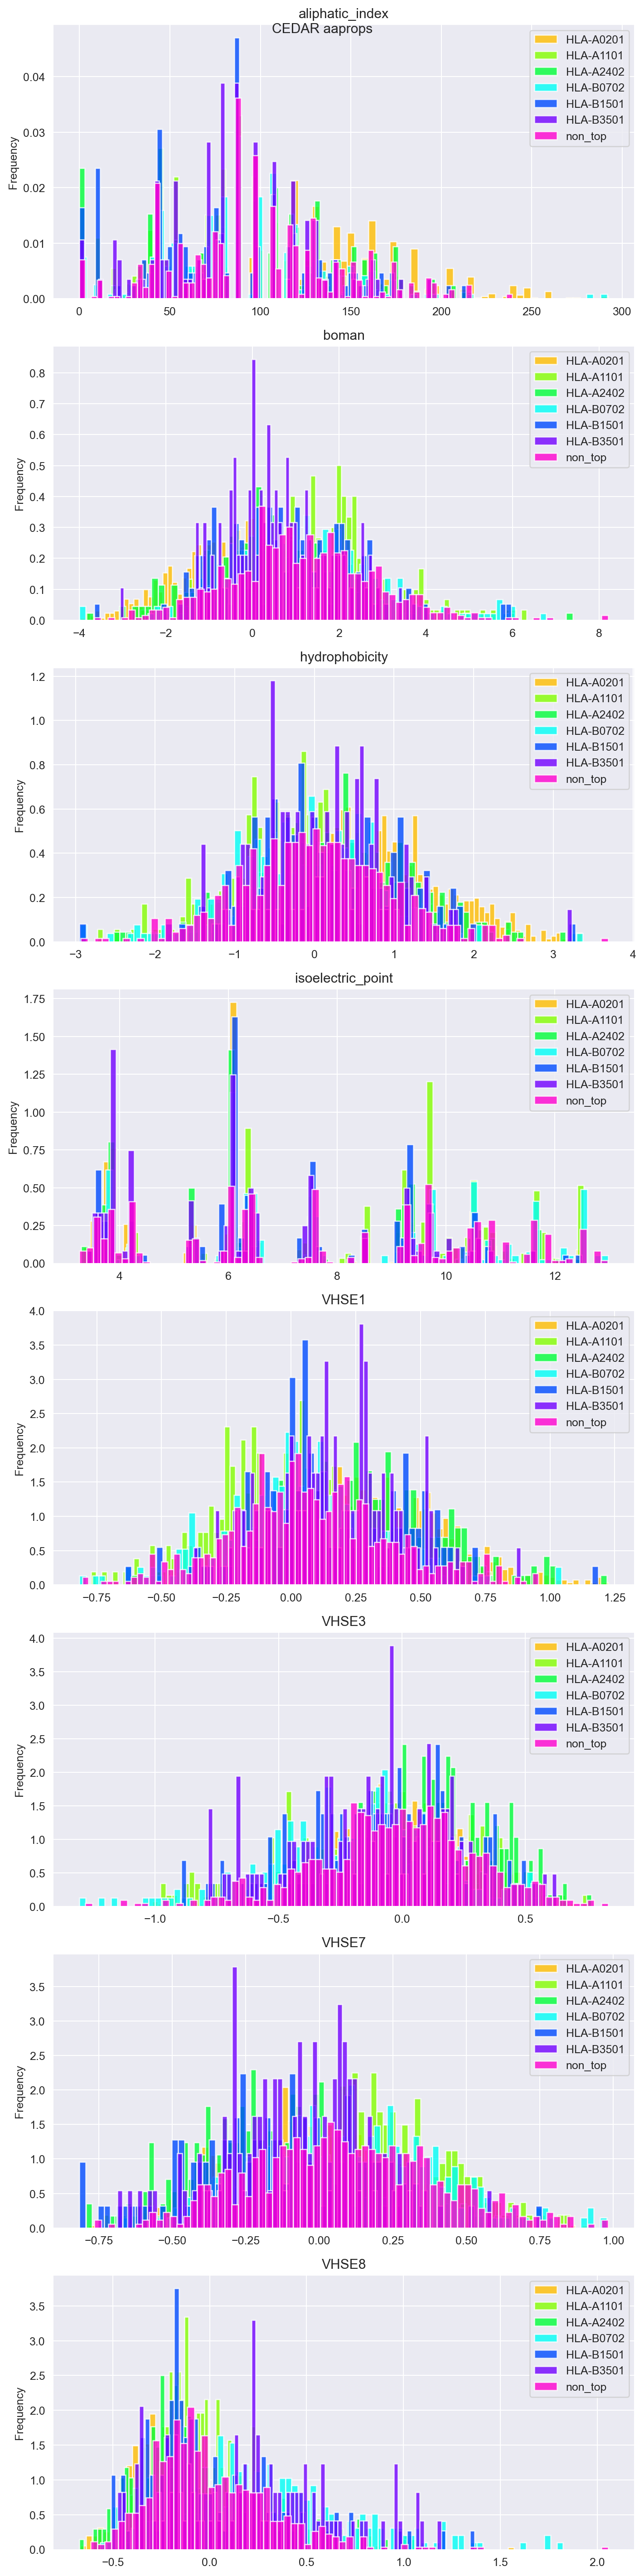

In [71]:
sns.set_palette('hsv',n_colors = 7)
f,a = plt.subplots(len(aa_cols), 1, figsize=(8, len(aa_cols)*4))
for col, axis in zip(aa_cols, a.ravel()):
    cedar_tmp.groupby('HLA')[col].plot(kind='hist', alpha=0.8, density=True, bins=75, ax= axis, title=col)
    axis.legend()
f.suptitle('CEDAR aaprops')
f.tight_layout()

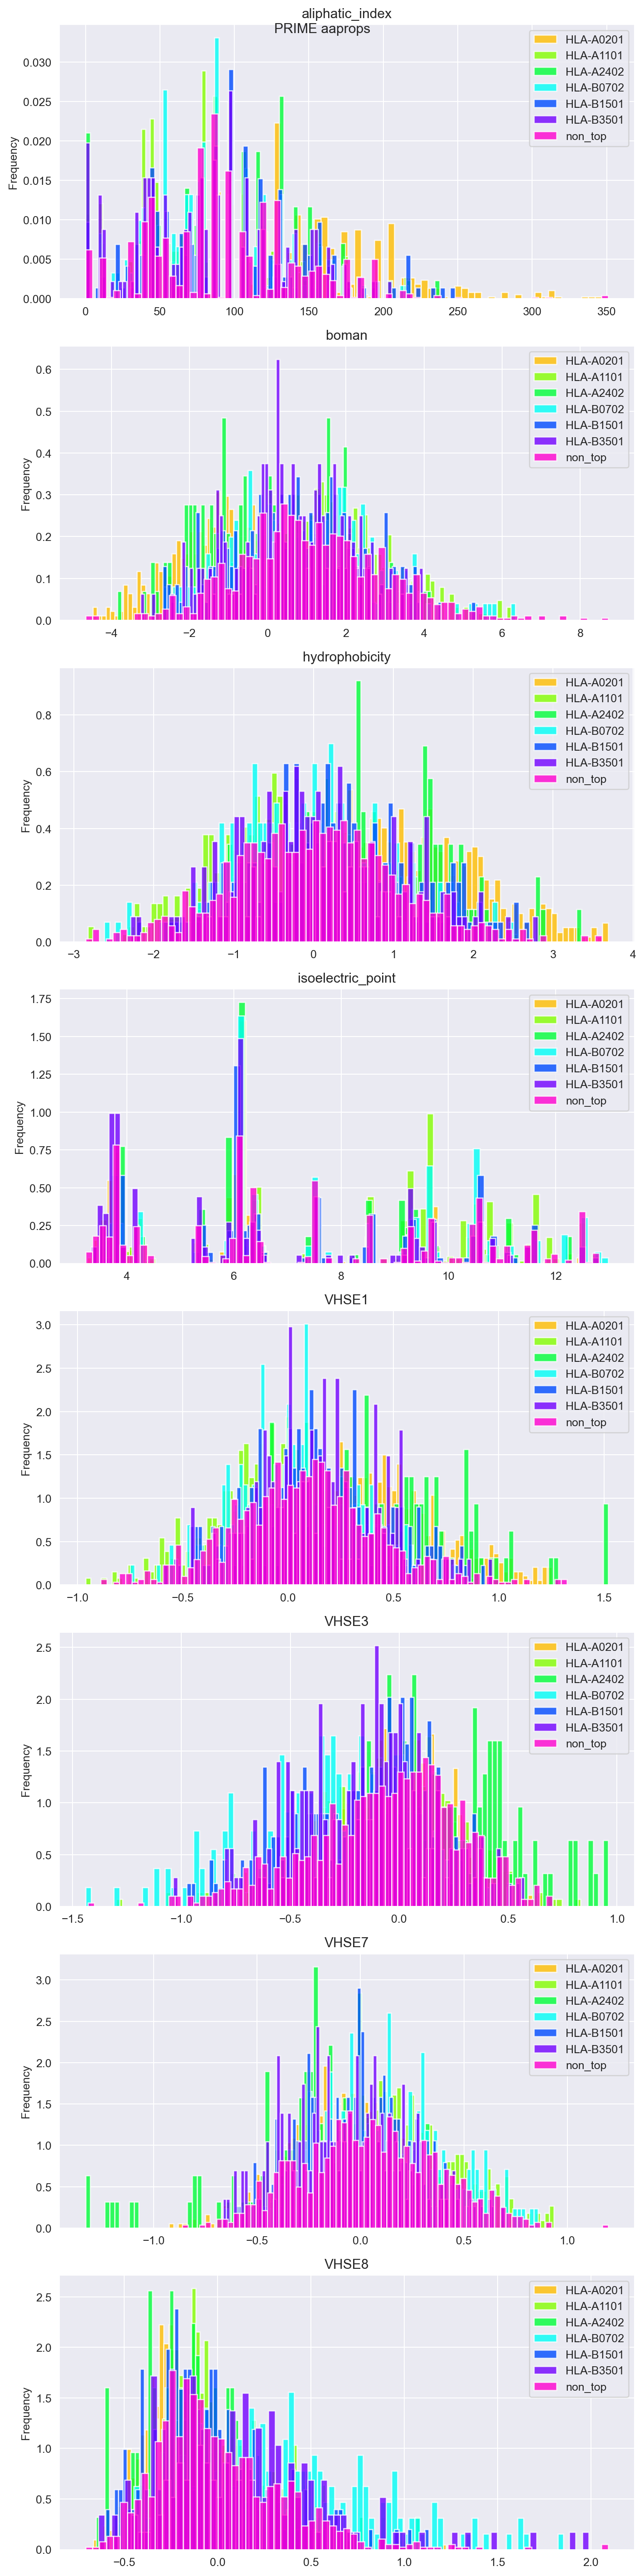

In [70]:
sns.set_palette('hsv',n_colors = 7)
f,a = plt.subplots(len(aa_cols), 1, figsize=(8, len(aa_cols)*4))
for col, axis in zip(aa_cols, a.ravel()):
    prime_tmp.groupby('HLA')[col].plot(kind='hist', alpha=0.8, density=True, bins=75, ax= axis, title=col)
    axis.legend()
f.suptitle('PRIME aaprops')
f.tight_layout()

# Results from various experiments

In [83]:
RDIR = '../output/221229_cedar_outputs/'
df_randomfold = pd.read_csv(f'{RDIR}221123_mutscore_cedar_randomfold_total_df.csv')
df_a11_rest = pd.read_csv(f'{RDIR}221223_cedar_a11rest_vs_top_total_df.csv')
df_noa11 = pd.read_csv(f'{RDIR}221323_mutscores_cedar_noa11_total_df.csv')

## Check random fold and No A11 to see if the weighting scheme still matches the total

In [102]:
df_randomfold.evalset.unique(), df_a11_rest.evalset.unique(), df_noa11.evalset.unique()

(array(['CEDAR', 'PRIME', 'IBEL'], dtype=object),
 array(['CEDAR_A11_REST', 'CEDAR_TOP_HLAS', 'CEDAR', 'PRIME'], dtype=object),
 array(['CEDAR', 'PRIME', 'IBEL', 'CEDAR_NOA11'], dtype=object))

In [96]:
reshape_randomfold = pd.concat([df_randomfold.query('evalset=="CEDAR"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_cedar = ('auc', 'mean'),
                                                  mean_auc01_cedar = ('auc_01', 'mean'),
                                                  mean_prauc_cedar = ('prauc', 'mean')),
                                df_randomfold.query('evalset=="PRIME"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_prime = ('auc', 'mean'),
                                                  mean_auc01_prime = ('auc_01', 'mean'),
                                                  mean_prauc_prime = ('prauc', 'mean')),
                                df_randomfold.query('evalset=="IBEL"').drop(columns=['evalset'])\
                                             .groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key'])\
                                             .agg(mean_auc_ibel = ('auc', 'mean'),
                                                  mean_auc01_ibel = ('auc_01', 'mean'),
                                                  mean_prauc_ibel = ('prauc', 'mean'))], axis=1)

In [98]:
reshape_randomfold.sort_values('mean_auc_cedar', ascending=False).head(5)

mean_auc_cedar  \
encoding weight           pep_col rank_col    key                                             
onehot   Inverted KL      Peptide EL_rank_mut aa_props                             0.749152   
         Inverted Shannon Peptide EL_rank_mut aa_props                             0.748657   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                       0.744850   
                                              blsm_mut_score-mutation_score        0.744379   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                       0.743985   

                                                                             mean_auc01_cedar  \
encoding weight           pep_col rank_col    key                                               
onehot   Inverted KL      Peptide EL_rank_mut aa_props                               0.596402   
         Inverted Shannon Peptide EL_rank_mut aa_props                               0.595779   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                         0.585458   
                                              blsm_mut_score-mutation_score          0.585202   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                         0.584687   

                                                                             mean_prauc_cedar  \
encoding weight           pep_col rank_col    key                                               
onehot   Inverted KL      Peptide EL_rank_mut aa_props                               0.474179   
         Inverted Shannon Peptide EL_rank_mut aa_props                               0.474831   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                         0.457944   
                                              blsm_mut_score-mutation_score          0.455525   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                         0.455261   

                                                                             mean_auc_prime  \
encoding weight           pep_col rank_col    key                                             
onehot   Inverted KL      Peptide EL_rank_mut aa_props                             0.658598   
         Inverted Shannon Peptide EL_rank_mut aa_props                             0.657875   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                       0.662508   
                                              blsm_mut_score-mutation_score        0.660137   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                       0.660923   

                                                                             mean_auc01_prime  \
encoding weight           pep_col rank_col    key                                               
onehot   Inverted KL      Peptide EL_rank_mut aa_props                               0.524696   
         Inverted Shannon Peptide EL_rank_mut aa_props                               0.523725   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                         0.563729   
                                              blsm_mut_score-mutation_score          0.563766   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                         0.562386   

                                                                             mean_prauc_prime  \
encoding weight           pep_col rank_col    key                                               
onehot   Inverted KL      Peptide EL_rank_mut aa_props                               0.080758   
         Inverted Shannon Peptide EL_rank_mut aa_props                               0.080347   
         Inverted KL      Peptide EL_rank_mut blsm_mut_score                         0.101900   
                                              blsm_mut_score-mutation_score          0.099863   
         Inverted Shannon Peptide EL_rank_mut blsm_mut_score                         0.100828   

                         

In [99]:
reshape_randomfold.sort_values('mean_auc_prime', ascending=False).head(5)

mean_auc_cedar  \
encoding weight pep_col rank_col    key                                                                 
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                           0.723334   
                                    dissimilarity_score-blsm_mut_score-mutation_score        0.726552   
                                    blsm_mut_score-mutation_score                            0.724585   
                                    dissimilarity_score-core_blsm_mut_score                  0.722672   
                                    core_blsm_mut_score                                      0.720116   

                                                                                       mean_auc01_cedar  \
encoding weight pep_col rank_col    key                                                                   
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                             0.570213   
                                    dissimilarity_score-blsm_mut_score-mutation_score          0.573854   
                                    blsm_mut_score-mutation_score                              0.570748   
                                    dissimilarity_score-core_blsm_mut_score                    0.569770   
                                    core_blsm_mut_score                                        0.566077   

                                                                                       mean_prauc_cedar  \
encoding weight pep_col rank_col    key                                                                   
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                             0.414188   
                                    dissimilarity_score-blsm_mut_score-mutation_score          0.421328   
                                    blsm_mut_score-mutation_score                              0.413854   
                                    dissimilarity_score-core_blsm_mut_score                    0.416006   
                                    core_blsm_mut_score                                        0.408719   

                                                                                       mean_auc_prime  \
encoding weight pep_col rank_col    key                                                                 
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                           0.714440   
                                    dissimilarity_score-blsm_mut_score-mutation_score        0.714349   
                                    blsm_mut_score-mutation_score                            0.714268   
                                    dissimilarity_score-core_blsm_mut_score                  0.714218   
                                    core_blsm_mut_score                                      0.714140   

                                                                                       mean_auc01_prime  \
encoding weight pep_col rank_col    key                                                                   
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                             0.582619   
                                    dissimilarity_score-blsm_mut_score-mutation_score          0.589565   
                                    blsm_mut_score-mutation_score                              0.581625   
                                    dissimilarity_score-core_blsm_mut_score                    0.589332   
                                    core_blsm_mut_score                                        0.583196   

                                                                                       mean_prauc_prime  \
encoding weight pep_col rank_col    key                                                                   
onehot   Mask   Peptide EL_rank_mut blsm_mut_score                                             0.111018   
                                    dissimil

In [100]:
reshape_randomfold.sort_values('mean_auc_ibel', ascending=False).head(5)

mean_auc_cedar  \
encoding weight pep_col rank_col        key                                                                  
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                   0.700179   
                                        dissimilarity_score-blsm_mut_score-mutation_score         0.702413   
                                        dissimilarity_score                                       0.699320   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...        0.700516   
                                        dissimilarity_score-blsm_mut_score                        0.703097   

                                                                                            mean_auc01_cedar  \
encoding weight pep_col rank_col        key                                                                    
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                     0.563440   
                                        dissimilarity_score-blsm_mut_score-mutation_score           0.565084   
                                        dissimilarity_score                                         0.562168   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...          0.562383   
                                        dissimilarity_score-blsm_mut_score                          0.564654   

                                                                                            mean_prauc_cedar  \
encoding weight pep_col rank_col        key                                                                    
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                     0.390889   
                                        dissimilarity_score-blsm_mut_score-mutation_score           0.392774   
                                        dissimilarity_score                                         0.386653   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...          0.389839   
                                        dissimilarity_score-blsm_mut_score                          0.392845   

                                                                                            mean_auc_prime  \
encoding weight pep_col rank_col        key                                                                  
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                   0.676359   
                                        dissimilarity_score-blsm_mut_score-mutation_score         0.674380   
                                        dissimilarity_score                                       0.677122   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...        0.675438   
                                        dissimilarity_score-blsm_mut_score                        0.675463   

                                                                                            mean_auc01_prime  \
encoding weight pep_col rank_col        key                                                                    
BL62LO   Mask   Peptide trueHLA_EL_rank dissimilarity_score-core_blsm_mut_score                     0.522960   
                                        dissimilarity_score-blsm_mut_score-mutation_score           0.522465   
                                        dissimilarity_score                                         0.524188   
                                        dissimilarity_score-core_blsm_mut_score-core_mu...          0.521898   
                                        dissimilarity_score-blsm_mut_score                          0.523075   

                                                                                            mean_prauc_prime  \
encoding weight pep_col rank_col        key                                        

## Check A11 + rest vs other Top HLAs and see if there's difference in behaviour